In [1]:
%pip install 'scipy>=1.8'
%pip install 'networkx<2.7'
%pip install igraph
%pip install pandas 
%pip install infomap

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'scipy"

[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


The system cannot find the file specified.


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\python310\lib\site-packages (1.5.3)




[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


# ML models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

from collections import Counter

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Speed up hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import networkx as nx
import infomap


In [3]:
# PATH = './kaggle/input/healthcare-provider-fraud-detection-analysis/'
PATH = './'



In [4]:
inpatients = pd.read_csv(PATH + 'Train_Inpatientdata-1542865627584.csv')
outpatients = pd.read_csv(PATH + 'Train_Outpatientdata-1542865627584.csv')
beneficiaries = pd.read_csv(PATH + 'Train_Beneficiarydata-1542865627584.csv')

labels = pd.read_csv(PATH + 'Train-1542865627584.csv')


In [5]:
df1 = inpatients[['BeneID', 'ClaimID', 'Provider',
                  'InscClaimAmtReimbursed', 'AttendingPhysician', 'DeductibleAmtPaid']]
df2 = outpatients[['BeneID', 'ClaimID', 'Provider',
                   'InscClaimAmtReimbursed', 'AttendingPhysician', 'DeductibleAmtPaid']]
df3 = beneficiaries[['BeneID', 'Gender', 'Race', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                     'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']]


df = pd.concat([df1, df2])

df = df.set_index('Provider').join(labels.set_index('Provider')).reset_index(
).set_index('BeneID').join(df3.set_index('BeneID')).reset_index()

df['PotentialFraud'] = df['PotentialFraud'].replace(
    "No", 0).replace("Yes", 1).astype(int)

df.head()


,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE100000,PRV57172,CLM126832,50,PHY383401,0.0,1,1,1,12,12,0,0,120,30
1,BENE100000,PRV57172,CLM351838,70,PHY370909,0.0,1,1,1,12,12,0,0,120,30
2,BENE100001,PRV52145,CLM626521,10,PHY430032,0.0,0,1,1,12,12,0,0,2530,540
3,BENE100001,PRV54683,CLM633318,100,PHY408282,0.0,0,1,1,12,12,0,0,2530,540
4,BENE100001,PRV54890,CLM332544,90,PHY343317,0.0,0,1,1,12,12,0,0,2530,540


In [6]:
df['AttendingPhysician'].str.removeprefix("PHY").astype(float).min()


311001.0

In [7]:
df['Provider'] = df['Provider'].str.removeprefix("PRV").astype(int) + 1_000_000
df['AttendingPhysician'] = df['AttendingPhysician'].str.removeprefix(
    "PHY").fillna(0).astype(int) + 2_000_000
df['BeneID'] = df['BeneID'].str.removeprefix(
    "BENE").fillna(0).astype(int) + 3_000_000

df


,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,3100000,1057172,CLM126832,50,2383401,0.0,1,1,1,12,12,0,0,120,30
1,3100000,1057172,CLM351838,70,2370909,0.0,1,1,1,12,12,0,0,120,30
2,3100001,1052145,CLM626521,10,2430032,0.0,0,1,1,12,12,0,0,2530,540
3,3100001,1054683,CLM633318,100,2408282,0.0,0,1,1,12,12,0,0,2530,540
4,3100001,1054890,CLM332544,90,2343317,0.0,0,1,1,12,12,0,0,2530,540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,3099999,1054670,CLM475422,80,2351000,0.0,0,2,1,12,12,0,0,1270,690
558207,3099999,1054670,CLM750563,50,2359641,0.0,0,2,1,12,12,0,0,1270,690
558208,3099999,1055510,CLM187739,60,2318212,0.0,0,2,1,12,12,0,0,1270,690
558209,3099999,1055826,CLM359214,80,2341548,0.0,0,2,1,12,12,0,0,1270,690


In [8]:
df.shape


(558211, 15)

In [9]:
#trying collusion between provider & physician
source = 'Provider'
target = 'BeneID'

G = nx.from_pandas_edgelist(df, source=source, target=target)


In [10]:
import plotly.graph_objs as go

# Consider subgraph for plotting
df_plotting = df.sample(n=1_000, random_state=1)

H = nx.from_pandas_edgelist(df_plotting, source=source, target=target)
pos = nx.random_layout(H)

# Create Edges
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#010203'),
    hoverinfo='none',
    mode='lines')

for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    mode='markers',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=False,
        color=[],
        size=12,
        colorbar=dict(
            thickness=35,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in H.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# add color to node points
for node, adjacencies in enumerate(H.adjacency()):
    node_trace['marker']['color'] += tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0])

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                title='<br>Network Graph of Provider & Beneficiary \n\n',
                titlefont=dict(size=16),
                showlegend=False,
                margin=dict(b=20, l=5, r=5, t=40),
                annotations=[dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002)],
                xaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


In [11]:
# defining a dictionary of graph features
nodes_info_dict = {
    # 'closeness_centrality': nx.closeness_centrality,
    'eigenvector_centrality': nx.eigenvector_centrality_numpy,
    'pagerank': nx.pagerank
}

columns_with_node_infos = ['degree'] + list(nodes_info_dict.keys())

nodes_info = pd.DataFrame.from_dict(dict(nx.degree(G)), orient='index').rename(
    columns={0: 'degree'}).reset_index()

# computing graph features for each node
for info, fun in nodes_info_dict.items():
    temp = pd.DataFrame.from_dict(fun(G), orient='index').rename(columns = {0 : info}).reset_index()
    nodes_info = nodes_info.merge(temp, on='index')

nodes_info = nodes_info.rename(columns = {'index': 'Beneficiary'})

# adding graph features to the dataframe
df_enriched = df.merge(nodes_info, left_on = 'Provider',
                           right_on='Beneficiary', how='left').drop('Beneficiary', axis=1)
df_enriched.rename(columns = {k:'Provider_'+k for k in columns_with_node_infos}, inplace = True)

df_enriched = df_enriched.merge(nodes_info, left_on = 'BeneID',
                           right_on='Beneficiary', how='left').drop('Beneficiary', axis=1)
df_enriched.rename(columns = {k:'Beneficiary_'+k for k in columns_with_node_infos}, inplace = True)

<AxesSubplot:>

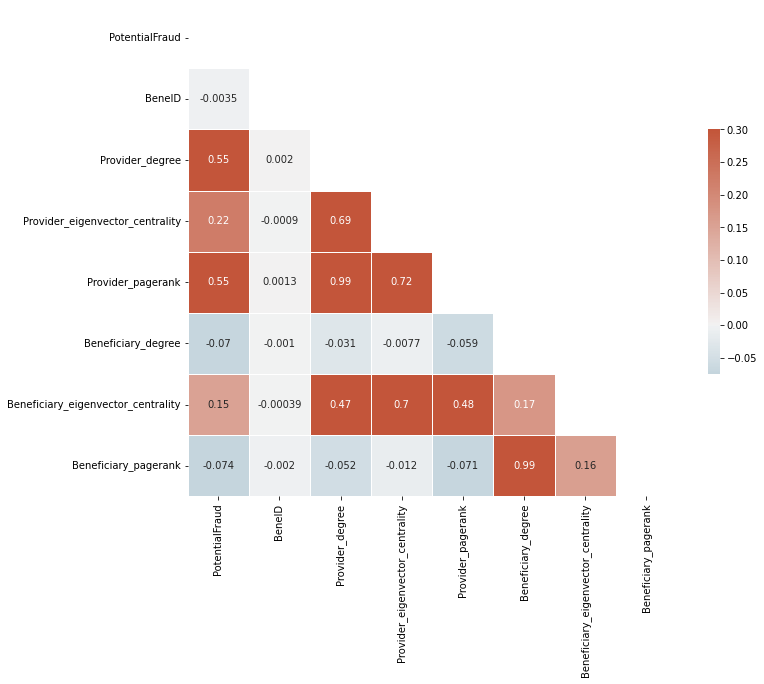

In [12]:
import seaborn as sns

corr_data = df_enriched[['PotentialFraud',
                         'BeneID',
                         'Provider_degree',
                         #                 'Provider_closeness_centrality',
                         'Provider_eigenvector_centrality',
                         'Provider_pagerank',
                         'Beneficiary_degree',
                         #                 'Beneficiary_closeness_centrality',
                         'Beneficiary_eigenvector_centrality',
                         'Beneficiary_pagerank']]

# Compute the correlation matrix
corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [13]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    im = infomap.Infomap(two_level=True, silent=True)

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        im.addLink(*e)

    print("Find communities with Infomap...")
    im.run()

    print(
        f"Found {im.num_top_modules} modules with codelength {im.codelength:.8f} bits")

    communities = {}
    for node, module in im.modules:
        communities[node] = module

    nx.set_node_attributes(G, communities, 'community')

    return G


def drawNetwork(G):
    # position map
    pos = nx.spectral_layout(I)
    # community ids
    communities = [v for k, v in nx.get_node_attributes(
        I, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(
        ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(
        ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(I, pos)


# Draw nodes
    nodeCollection = nx.draw_networkx_nodes(I,
                                            pos=pos,
                                            node_size=1,
                                            node_color=communities,
                                            cmap=cmapLight
                                            )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    plt.axis('off')
    plt.xlim(np.vstack(list(pos.values()))[:, 0].min(
    ) + 0.01, np.vstack(list(pos.values()))[:, 0].max())
    plt.ylim(np.vstack(list(pos.values()))[:, 1].min(
    ), np.vstack(list(pos.values()))[:, 1].max())
    plt.show()


In [14]:
G = findCommunities(G)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 1301 modules with codelength 10.48422830 bits


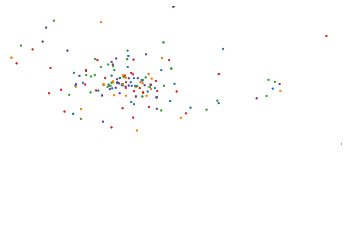

In [15]:
I = G.subgraph(list(H.nodes()))

drawNetwork(I)


In [16]:
df_communities = pd.DataFrame([[k, v] for k, v in nx.get_node_attributes(
    G, 'community').items()], columns=["BeneID", "Beneficiary_cluster"])
df_communities.head(2)


,BeneID,Beneficiary_cluster
0,1057172,114
1,3100000,114


In [19]:
df_enriched = df_enriched.set_index('BeneID').join(
    df_communities.set_index('BeneID'), how="left", rsuffix='_comm').reset_index()

df_enriched.head(2)

,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,...,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Provider_degree,Provider_eigenvector_centrality,Provider_pagerank,Beneficiary_degree,Beneficiary_eigenvector_centrality,Beneficiary_pagerank,Beneficiary_cluster
0,3011001,1055907,CLM66048,5000,2318495,1068.0,0,1,1,12,...,3204,60,70,204,0.000802,0.000242,3,0.000025,0.000005,614
1,3011001,1055912,CLM46614,26000,2390922,1068.0,1,1,1,12,...,3204,60,70,100,0.000543,0.000120,3,0.000025,0.000005,614


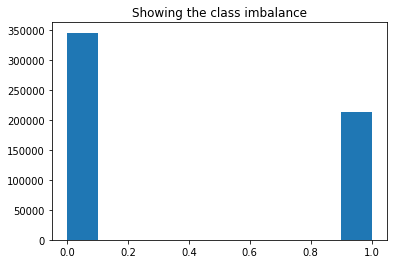

The Class Imbalance: Counter({0: 345415, 1: 212796})


In [20]:
classes = df_enriched['PotentialFraud'].to_numpy()

plt.hist(classes)
plt.title("Showing the class imbalance")
plt.show()

print('The Class Imbalance: %s' % Counter(classes))


SMOTE

In [21]:
# Splitting feature data from label data
X, y = df_enriched[['InscClaimAmtReimbursed',
                    'DeductibleAmtPaid',
                    'Gender',
                    'Race',
                    'NoOfMonths_PartACov',
                    'NoOfMonths_PartBCov',
                    'IPAnnualReimbursementAmt',
                    'IPAnnualDeductibleAmt',
                    'OPAnnualReimbursementAmt',
                    'OPAnnualDeductibleAmt',
                    'Provider_degree',
                    #  'Provider_closeness_centrality',
                    'Provider_eigenvector_centrality',
                    'Provider_pagerank',
                    'Beneficiary_degree',
                    #  'Beneficiary_closeness_centrality',
                    'Beneficiary_eigenvector_centrality',
                    'Beneficiary_pagerank',
                    'Beneficiary_cluster']], df_enriched['PotentialFraud']

print("Original shapes: ", "X:", X.shape, " y:", y.shape)


Original shapes:  X: (558211, 17)  y: (558211,)


In [22]:

X = X.fillna(0)


In [25]:
%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


0    345415
1    345415
Name: PotentialFraud, dtype: int64

In [26]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.4, random_state=69)
print(f"Shapes after splitting:\n\nX_train: {X_train.shape}, y_train: {y_train.shape}\
      \nX_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes after splitting:

X_train: (414498, 17), y_train: (414498,)      
X_test: (276332, 17), y_test: (276332,)


In [27]:
y_train.value_counts()

0    207360
1    207138
Name: PotentialFraud, dtype: int64

In [28]:
accuracy = []
feature_names = ["Baseline", "Graph Features",
                 "Graph Features with Community Detection"]
features = [
    # Baseline features
    ['InscClaimAmtReimbursed',
     'DeductibleAmtPaid',
     'Gender',
     'Race',
     'NoOfMonths_PartACov',
     'NoOfMonths_PartBCov',
     'IPAnnualReimbursementAmt',
     'IPAnnualDeductibleAmt',
     'OPAnnualReimbursementAmt',
     'OPAnnualDeductibleAmt'],
    # # Baseline + Graph Features
    ['InscClaimAmtReimbursed',
     'DeductibleAmtPaid',
     'Gender',
     'Race',
     'NoOfMonths_PartACov',
     'NoOfMonths_PartBCov',
     'IPAnnualReimbursementAmt',
     'IPAnnualDeductibleAmt',
     'OPAnnualReimbursementAmt',
     'OPAnnualDeductibleAmt',
     'Provider_degree',
     #  'Provider_closeness_centrality',
     'Provider_eigenvector_centrality',
     'Provider_pagerank',
     'Beneficiary_degree',
     #  'Beneficiary_closeness_centrality',
     'Beneficiary_eigenvector_centrality',
     'Beneficiary_pagerank'],
#     # # Baseline + Graph Features + Community Detection
    ['InscClaimAmtReimbursed',
     'DeductibleAmtPaid',
     'Gender',
     'Race',
     'NoOfMonths_PartACov',
     'NoOfMonths_PartBCov',
     'IPAnnualReimbursementAmt',
     'IPAnnualDeductibleAmt',
     'OPAnnualReimbursementAmt',
     'OPAnnualDeductibleAmt',
     'Provider_degree',
     #  'Provider_closeness_centrality',
     'Provider_eigenvector_centrality',
     'Provider_pagerank',
     'Beneficiary_degree',
     #  'AttendingPhysician_closeness_centrality',
     'Beneficiary_eigenvector_centrality',
     'Beneficiary_pagerank',
     'Beneficiary_cluster']
]

hyper_parameter_grids_RFC = [
    {  # Grid 1: No regularization
        "randomforestclassifier__criterion": ['gini'],
        "randomforestclassifier__max_depth": [10, 20, 50, 100, 250, 300, 500],
        "randomforestclassifier__min_samples_split": [2, 3, 5, 10, 20, 30],
    },
    {  # Grid 2: L2 regularization
        "randomforestclassifier__criterion": ['entropy'],
        "randomforestclassifier__max_depth": [10, 20, 50, 100, 250, 300, 500],
        "randomforestclassifier__min_samples_split": [2, 3, 5, 10, 20, 30],

    },
]
pipeline_RFC = make_pipeline(
    StandardScaler(), RandomForestClassifier(random_state=69))


for feature in features:
    print("*" * 100)
    print("# Tuning hyper-parameters for accuracy")
    print("*" * 100)
    print()

    # This performs gridsearch, evaluating each set of hyper-parameters using k-fold
    # cross validation.
    clf = HalvingGridSearchCV(
        pipeline_RFC, hyper_parameter_grids_RFC, scoring="accuracy", cv=4, n_jobs=-1)

    X_train_subset = X_train[feature]
    X_test_subset = X_test[feature]

    clf.fit(X_train_subset, y_train)

    acc = round(clf.best_estimator_.score(X_test_subset, y_test) * 100, 2)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Best score on development set:")
    print()

    print(f"Accuracy: {acc}")
    accuracy.append(acc)

****************************************************************************************************
# Tuning hyper-parameters for accuracy
****************************************************************************************************



In [ ]:
from sklearn import metrics

y_pred_proba = clf.best_estimator_.steps[1][1].predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

In [ ]:
import plotly.graph_objects as go
import numpy as np


# Generate a trace for ROC curve
trace0 = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name='ROC curve'
)

# Only label every nth point to avoid cluttering
n = 10  
indices = np.arange(len(thresholds)) % n == 0  # Choose indices where index mod n is 0

trace1 = go.Scatter(
    x=fpr[indices], 
    y=tpr[indices], 
    mode='markers+text', 
    name='Threshold points', 
    text=[f"Thr={thr:.2f}" for thr in thresholds[indices]], 
    textposition='top center'
)


# Diagonal line
trace2 = go.Scatter(
    x=[0, 1], 
    y=[0, 1], 
    mode='lines', 
    name='Random (Area = 0.5)', 
    line=dict(dash='dash')
)

data = [trace0, trace1, trace2]

# Define layout with square aspect ratio
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    autosize=False,
    width=800,
    height=800,
    showlegend=False
)

# Define figure and add data
fig = go.Figure(data=data, layout=layout)

# Show figure
fig.show()

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is:", optimal_threshold)

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import roc_auc_score

# Assuming fpr, tpr, thresholds are already calculated as before
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Generate a trace for ROC curve
trace0 = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name=f'ROC curve (Area = {roc_auc:.2f})'
)

# Only label every nth point to avoid cluttering
n = 10
indices = np.arange(len(thresholds)) % n == 0  # Choose indices where index mod n is 0

trace1 = go.Scatter(
    x=fpr[indices], 
    y=tpr[indices], 
    mode='markers+text', 
    name='Threshold points', 
    text=[f"Thr={thr:.2f}" for thr in thresholds[indices]], 
    textposition='top center'
)

# Diagonal line
trace2 = go.Scatter(
    x=[0, 1], 
    y=[0, 1], 
    mode='lines', 
    name='Random (Area = 0.5)', 
    line=dict(dash='dash')
)

data = [trace0, trace1, trace2]

# Define layout with square aspect ratio
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    autosize=False,
    width=800,
    height=800,
    showlegend=True
)

# Define figure and add data
fig = go.Figure(data=data, layout=layout)

# Show figure
fig.show()

In [ ]:
### import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
#### Function for serching best parameters which is fiting the model and shows best results for specified method.               
def grid(method, parameters):
    
    grid_1 = GridSearchCV(method, parameters, scoring = make_scorer(accuracy_score), cv=5, n_jobs = -1)
    grid_2 = GridSearchCV(method, parameters, scoring = make_scorer(roc_auc_score), cv=5, n_jobs = -1)
    
    grid_1.fit(X_train, y_train)
    print('Best parameters using accuracy score:')
    print(grid_1.best_params_)

    grid_2.fit(X_train, y_train)
    print('Best parameters usin ROC accuracy score:')
    print(grid_2.best_params_)

In [ ]:
x = np.array(list(map(int, np.linspace(1, 31, 31))))

parameters = { 
        'hidden_layer_sizes' : list(zip(np.tile(x, len(x)), np.repeat(x, len(x))))
}

grid(MLPClassifier ( activation = 'logistic', random_state = 5, max_iter= 100), parameters)

In [ ]:
## write Master Learn class which we are going to use for our analysis
class MasterL:
    
    def __init__(self, model, #### model is a method which we are going to use for detecting FRAUDS. For example: sklearn.svm
                 X= X_train, y= y_train, test= X_test, ### data
                 **kvars  #### additional key parameters for model
                ):
        self.clf = model( **kvars)
        self.methodname = model.__name__
        self.X_train = X
        self.y_train = y
        self.X_test = test
        self.fit(self.X_train, self.y_train)
        self.predicted = self.predict(test)
        
    def fit (self, X, y):
        self.clf.fit(X, y)
    
    def predict(self, x):
        return self.clf.predict(x)
       
    def get_score(self, y = y_test, roc = True, params = False):
        accuracy = accuracy_score(self.predicted, y)
        if params:
            print(self.clf.get_params())
        print(self.methodname+ " metrics:\n")
        print(" Accuracy Score: %.2f%%" % (accuracy * 100.0))
        print(" Confusion matrix:", "\n",confusion_matrix(y_true=y, y_pred=self.predicted))
        print( 'Classification report:\n', classification_report(y, self.predicted))
        if roc:
            print(" ROC Score: %.2f%%" % (roc_auc_score(y, self.clf.predict_proba(self.X_test)[:,1])))
    def plot_curves(self, y = y_test):   
        plt.figure(figsize=(17, 5))
        plt.subplot(131)
        # Plot the recall precision tradeoff        
        self.plot_pr_curve(y)
        plt.subplot(132)        
        self.plot_lern_curve(accuracy_score)     
        plt.subplot(133)
        self.plot_lern_curve(roc_auc_score)
        plt.show()
        
    def plot_pr_curve(self, y = y_test):
        
        plt.subplot(122)
        # Calculate average precision and the PR curve
        average_precision = average_precision_score(y, self.predicted)

        # Obtain precision and recall 
        precision, recall, _ = precision_recall_curve(y, self.clf.predict_proba(self.X_test)[:,1])
        
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format( average_precision))
    
    def plot_lern_curve(self, metrics):
        plt.title(self.methodname + " Learning Curves")
        plt.xlabel("Training examples")
        plt.ylabel("{}".format(' '.join(metrics.__name__.split('_')).title()))
        train_sizes, train_scores, test_scores = learning_curve(self.clf, self.X_train, self.y_train, n_jobs=-1, 
                                                                cv = ShuffleSplit(n_splits=5, test_size=.25 , random_state = 5), 
                                                                train_sizes=np.linspace(0.5, 1.0, 10), scoring = make_scorer(metrics))
        train_scores_mean = np.mean(train_scores, axis=1) 
        test_scores_mean = np.mean(test_scores, axis=1) 
        #plt.grid()

        plt.plot(train_sizes,  train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes,  test_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        plt.legend(loc="best")
    
    def plot_roc_curve(self, y = y_test, models = None, fig = None):
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_subplot(121)
        
        self.roc_curves(ax, y, models)
        
        ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        
        plt.legend(loc="best")
        
        #if fig != None:
            #plt.savefig( fig, bbox_inches = 'tight')
       
    def roc_curves(self, p, y, M):
        if M == None:
            fpr, tpr, thresholds = roc_curve(y, self.clf.predict_proba(self.X_test)[:,1] )
            p.plot(fpr, tpr,  label=self.methodname )
        else:
            fpr, tpr, thresholds = roc_curve(y, self.clf.predict_proba(self.X_test)[:,1] )
            p.plot(fpr, tpr,  label=self.methodname )
            for i in M:
                fpr, tpr, thresholds = roc_curve(y, i.clf.predict_proba(i.X_test)[:,1] )
                p.plot(fpr, tpr,  label=i.methodname )

In [ ]:
ML5 = MasterL( MLPClassifier, activation = 'logistic', hidden_layer_sizes = (1, 6),random_state = 5, max_iter= 1000)
ML5.get_score()